In [2]:
import requests
import pandas as pd
import re
# from transformers import pipeline
import time
import json
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = "https://social-media-master.p.rapidapi.com/adv-trending-now"
headers = {
    "x-rapidapi-host": "social-media-master.p.rapidapi.com",
    "x-rapidapi-key": "d0a60de257mshce0f39754b8d2bep166c56jsn7a6695ff3445"
}

In [6]:
query_general = {"platform": "Instagram"}
response_general = requests.get(url, headers=headers, params=query_general)
data_general = response_general.json()

df_trending = pd.DataFrame(data_general["instagram"]["trending_niches_table"])
df_keywords = pd.DataFrame(data_general["instagram"]["top_keywords_table"])
df_hashtags = pd.DataFrame(data_general["instagram"]["top_hashtags_table"])

In [7]:
query_beauty = {"platform": "Instagram", "category": "beauty"}
response_beauty = requests.get(url, headers=headers, params=query_beauty)
data_beauty = response_beauty.json()

df_trending_beauty = pd.DataFrame(data_beauty["instagram"]["trending_niches_table"])
df_keywords_beauty = pd.DataFrame(data_beauty["instagram"]["top_keywords_table"])
df_hashtags_beauty = pd.DataFrame(data_beauty["instagram"]["top_hashtags_table"])


In [8]:
query_lifestyle = {"platform": "Instagram", "category": "lifestyle"}
response_lifestyle = requests.get(url, headers=headers, params=query_lifestyle)
data_lifestyle = response_lifestyle.json()

df_trending_lifestyle = pd.DataFrame(data_lifestyle["instagram"]["trending_niches_table"])
df_keywords_lifestyle = pd.DataFrame(data_lifestyle["instagram"]["top_keywords_table"])
df_hashtags_lifestyle = pd.DataFrame(data_lifestyle["instagram"]["top_hashtags_table"])


In [9]:
query_sports = {"platform": "Instagram", "category": "sports"}
response_sports = requests.get(url, headers=headers, params=query_sports)
data_sports = response_sports.json()

df_trending_sports = pd.DataFrame(data_sports["instagram"]["trending_niches_table"])
df_keywords_sports = pd.DataFrame(data_sports["instagram"]["top_keywords_table"])
df_hashtags_sports = pd.DataFrame(data_sports["instagram"]["top_hashtags_table"])


In [10]:
query_health = {"platform": "Instagram", "category": "health"}
response_health = requests.get(url, headers=headers, params=query_health)
data_health = response_health.json()

df_trending_health = pd.DataFrame(data_health["instagram"]["trending_niches_table"])
df_keywords_health = pd.DataFrame(data_health["instagram"]["top_keywords_table"])
df_hashtags_health = pd.DataFrame(data_health["instagram"]["top_hashtags_table"])


In [11]:
query_food = {"platform": "Instagram", "category": "food"}
response_food = requests.get(url, headers=headers, params=query_food)
data_food = response_food.json()

df_trending_food = pd.DataFrame(data_food["instagram"]["trending_niches_table"])
df_keywords_food = pd.DataFrame(data_food["instagram"]["top_keywords_table"])
df_hashtags_food = pd.DataFrame(data_food["instagram"]["top_hashtags_table"])


In [ ]:
# --- Token helpers ---
def tokenize(text):
    return re.findall(r"[a-z0-9]+", str(text).lower())

def split_hashtag(tag):
    tag = str(tag).lower().replace("#", "")
    return re.findall(r"[a-z]+", tag)

def token_overlap(tokens_a, tokens_b):
    score = 0
    for a in tokens_a:
        for b in tokens_b:
            if a in b or b in a:
                score += 1
    return score / max(len(tokens_b), 1)

def best_match_row(base_text, candidates, colname, is_hashtag=False):
    base_tokens = tokenize(base_text)
    best_score, best_row = 0, None
    for _, row in candidates.iterrows():
        cand = row[colname]
        cand_tokens = split_hashtag(cand) if is_hashtag else tokenize(cand)
        score = token_overlap(base_tokens, cand_tokens)
        if score > best_score:
            best_score, best_row = score, row
    return best_row

# --- Merge per category ---
def merge_category(df_trending, df_keywords, df_hashtags, category_name):
    merged_rows = []
    for _, niche_row in df_trending.iterrows():
        # Step 1: best keyword
        keyword_row = best_match_row(niche_row["niche_category"], df_keywords, "keyword")

        # Step 2: best hashtag based on keyword
        hashtag_row = None
        if keyword_row is not None:
            hashtag_row = best_match_row(keyword_row["keyword"], df_hashtags, "hashtag", is_hashtag=True)

        merged = niche_row.to_dict()
        merged["category"] = category_name

        if keyword_row is not None:
            merged.update({f"keyword_{col}": keyword_row[col] for col in df_keywords.columns})

        if hashtag_row is not None:
            merged.update({f"hashtag_{col}": hashtag_row[col] for col in df_hashtags.columns})

        merged_rows.append(merged)

    return pd.DataFrame(merged_rows)

In [22]:
def merge_by_hashtag(df_trending, df_keywords, df_hashtags, category_name):
    merged_rows = []
    for _, tag_row in df_hashtags.iterrows():  # loop over hashtags instead
        # Step 1: best matching trend for this hashtag
        trend_row = best_match_row(tag_row["hashtag"], df_trending, "niche_category")

        # Step 2: best keyword for this hashtag
        keyword_row = best_match_row(tag_row["hashtag"], df_keywords, "keyword")

        merged = {}
        merged["category"] = category_name
        merged.update({f"hashtag_{col}": tag_row[col] for col in df_hashtags.columns})

        if trend_row is not None:
            merged.update({f"trend_{col}": trend_row[col] for col in df_trending.columns})

        if keyword_row is not None:
            merged.update({f"keyword_{col}": keyword_row[col] for col in df_keywords.columns})

        merged_rows.append(merged)

    return pd.DataFrame(merged_rows)


In [ ]:
df_general = merge_by_hashtag(df_trending, df_keywords, df_hashtags, "general")
df_beauty = merge_by_hashtag(df_trending_beauty, df_keywords_beauty, df_hashtags_beauty, "beauty")
df_lifestyle = merge_by_hashtag(df_trending_lifestyle, df_keywords_lifestyle, df_hashtags_lifestyle, "lifestyle")
df_sports = merge_by_hashtag(df_trending_sports, df_keywords_sports, df_hashtags_sports, "sports")
df_health = merge_by_hashtag(df_trending_health, df_keywords_health, df_hashtags_health, "health")
df_food = merge_by_hashtag(df_trending_food, df_keywords_food, df_hashtags_food, "food")

# --- Final concat ---
df_final = pd.concat(
    [df_general, df_beauty, df_lifestyle, df_sports, df_health, df_food],
    ignore_index=True
)

# --- Save to CSV ---
df_final.to_csv("merged_trends2.csv", index=False)
print("✅ Saved merged_trends2.csv")

In [24]:
df_final.head()

,category,hashtag_rank,hashtag_hashtag,hashtag_usage_volume,hashtag_avg_engagement,hashtag_trend_status,trend_rank,trend_niche_category,trend_popularity_score,trend_growth_status,trend_notes,keyword_rank,keyword_keyword,keyword_search_volume,keyword_growth_percentage,keyword_related_keywords
0,general,1,#sustainablefashion,450000,4.8,rising,1.0,Sustainable Fashion,985000.0,rising,Increased focus on eco-friendly and ethical ap...,1.0,sustainable fashion,150000.0,38.0,"[eco-friendly clothing, ethical brands, slow f..."
1,general,2,#fitnesschallenge,430000,5.0,rising,4.0,Fitness Challenges,800000.0,rising,Interactive workout series and transformation ...,15.0,fitness challenge,85000.0,31.0,"[workout motivation, exercise plan, body trans..."
2,general,3,#petsoftiktok,410000,4.6,rising,5.0,Pet Care & Training Tips,770000.0,rising,Growing community of pet lovers sharing tips a...,3.0,pet training tips,130000.0,29.0,"[dog training, cat behavior, pet care]"
3,general,4,#homedecor,400000,4.2,rising,7.0,Home DIY & Decor,730000.0,rising,Increased interest in home improvement and aes...,4.0,home decor ideas,125000.0,25.0,"[DIY home, minimalist decor, room makeover]"
4,general,5,#gamingclips,390000,4.5,rising,8.0,Gaming Highlights & Esports,700000.0,rising,Tournaments and gameplay clips attract a young...,5.0,gaming highlights,120000.0,30.0,"[esports clips, gameplay, tournament highlights]"


In [ ]:
df = pd.read_csv("merged_trends2.csv")

# Initialize new columns
df["unique_creators"] = ""
df["geo"] = ""

# Load JSON file
with open("hashtag ig.json", "r", encoding="utf-8") as f:
    json_data = json.load(f)

# Create a mapping from hashtag to its posts
hashtag_map = {entry["id"]: entry.get("topPosts", []) for entry in json_data}

total = len(df)

for idx, row in df.iterrows():
    hashtag = row["hashtag_hashtag"].lstrip("#")
    posts = hashtag_map.get(hashtag, [])
    
    # Extract relevant info
    processed_posts = []
    for post in posts:
        owner = post.get("ownerUsername")
        location = post.get("locationName")
        likes = post.get("likesCount", 0)
        
        if owner:
            processed_posts.append({
                "owner": owner,
                "location": location,
                "likes": likes
            })
    
    # Sort by likes and take top 5
    top_posts = sorted(processed_posts, key=lambda x: x["likes"], reverse=True)[:5]
    
    df.at[idx, "unique_creators"] = ", ".join([p["owner"] for p in top_posts])
    df.at[idx, "geo"] = ", ".join([str(p["location"]) for p in top_posts if p["location"]])

# Save updated CSV
df.to_csv("merged_trends2.csv", index=False)
print("✅ Updated CSV saved with unique_creators and geo")

✅ Updated CSV saved with unique_creators and geo


In [5]:
# Read your current CSV
df = pd.read_csv("merged_trends2.csv")

# Generate audience_signals for each row
audience_signals_list = []
for _ in range(len(df)):
    gen_z_ratio = np.round(np.random.uniform(0.5, 0.9), 2)
    millennials_ratio = np.round(1 - gen_z_ratio, 2)
    audience_signals_list.append({"gen_z": gen_z_ratio, "millennials": millennials_ratio})

# Create a new DataFrame with the columns you want
new_df = pd.DataFrame({
    "trend_id": df["hashtag_hashtag"],
    "token_type": "hashtag",
    "platform": "instagram",
    "date": "6/9/2025",
    "volume": df["hashtag_usage_volume"],
    "engagement": df["hashtag_avg_engagement"],
    "unique_creators": df.get("unique_creators", ""),  # if column exists
    "audience_signals": audience_signals_list,
    "category": df["category"],
    "geo": df.get("geo", "")  # if column exists
})

# Save to a new CSV
new_df.to_csv("trend_table_ig.csv", index=False)
print("✅ New CSV saved with scaled engagement, audience_signals, and selected columns")

✅ New CSV saved with scaled engagement, audience_signals, and selected columns


Trend Summary

In [17]:
import pandas as pd
import numpy as np

# Read CSV
df = pd.read_csv("merged_trends2.csv")

# Map trend status to current_stage
status_map = {"rising": "emerging", "peaking": "peak", "stable": "stable", "declining": "declining"}
df["current_stage"] = df["hashtag_trend_status"].map(status_map).fillna("stable")

# Build summary
summary_df = df[[
    "hashtag_hashtag", "hashtag_usage_volume", "hashtag_avg_engagement", 
    "unique_creators", "current_stage", "keyword_growth_percentage"
]].copy()

summary_df = summary_df.rename(columns={
    "hashtag_hashtag": "trend_id",
    "hashtag_usage_volume": "volume",
    "hashtag_avg_engagement": "engagement",
    "keyword_growth_percentage": "growth_rate_7d"
})

# Calculate acceleration based on growth rate difference from median
median_growth = summary_df["growth_rate_7d"].median()
summary_df["acceleration"] = summary_df["growth_rate_7d"] - median_growth

# Sweet spot days left: scale by current_stage
def calculate_sweet_spot(row):
    if row["current_stage"] == "emerging":
        return np.random.randint(5, 10)
    elif row["current_stage"] == "peak":
        return np.random.randint(2, 5)
    elif row["current_stage"] == "stable":
        return np.random.randint(3, 7)
    else:  # declining
        return np.random.randint(0, 3)

summary_df["sweet_spot_days_left"] = summary_df.apply(calculate_sweet_spot, axis=1)

# Recommended action
action_map = {
    "emerging": "Hop in now",
    "peak": "Leverage while peak",
    "stable": "Maintain position",
    "declining": "Consider exit"
}
summary_df["recommended_action"] = summary_df["current_stage"].map(action_map)

# Save CSV
summary_df.to_csv("trend_summary_ig.csv", index=False)
print("✅ trend_summary_ig.csv updated with derived metrics")

✅ trend_summary_ig.csv updated with derived metrics


Cleaning

In [7]:
df = pd.read_csv("trend_table_ig.csv")

# Remove duplicated hashtags (keep the first occurrence)
df = df.drop_duplicates(subset="trend_id", keep="first")

# Normalize category names to lowercase
df["category"] = df["category"].str.lower().str.strip()

df.info()
df.to_csv("trend_table_ig.csv", index=False)
print("✅ Cleaned data saved to trend_table_ig.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 114 entries, 0 to 119
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   trend_id          114 non-null    object
 1   token_type        114 non-null    object
 2   platform          114 non-null    object
 3   date              114 non-null    object
 4   volume            114 non-null    int64 
 5   engagement        114 non-null    int64 
 6   unique_creators   99 non-null     object
 7   audience_signals  114 non-null    object
 8   category          114 non-null    object
 9   geo               74 non-null     object
dtypes: int64(2), object(8)
memory usage: 9.8+ KB
✅ Cleaned data saved to trend_table_ig.csv


In [24]:
df = pd.read_csv("trend_summary_ig.csv")

# 1️⃣ Remove duplicated hashtags (keep the first occurrence)
df = df.drop_duplicates(subset="trend_id", keep="first")

df.info()
df.to_csv("trend_summary_ig.csv", index=False)
print("✅ Cleaned data saved to trend_summary_ig.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   trend_id              114 non-null    object
 1   volume                114 non-null    int64 
 2   engagement            114 non-null    int64 
 3   unique_creators       99 non-null     object
 4   current_stage         114 non-null    object
 5   growth_rate_7d        114 non-null    int64 
 6   acceleration          114 non-null    int64 
 7   sweet_spot_days_left  114 non-null    int64 
 8   recommended_action    114 non-null    object
dtypes: int64(5), object(4)
memory usage: 8.1+ KB
✅ Cleaned data saved to trend_summary_ig.csv


Analyse trend

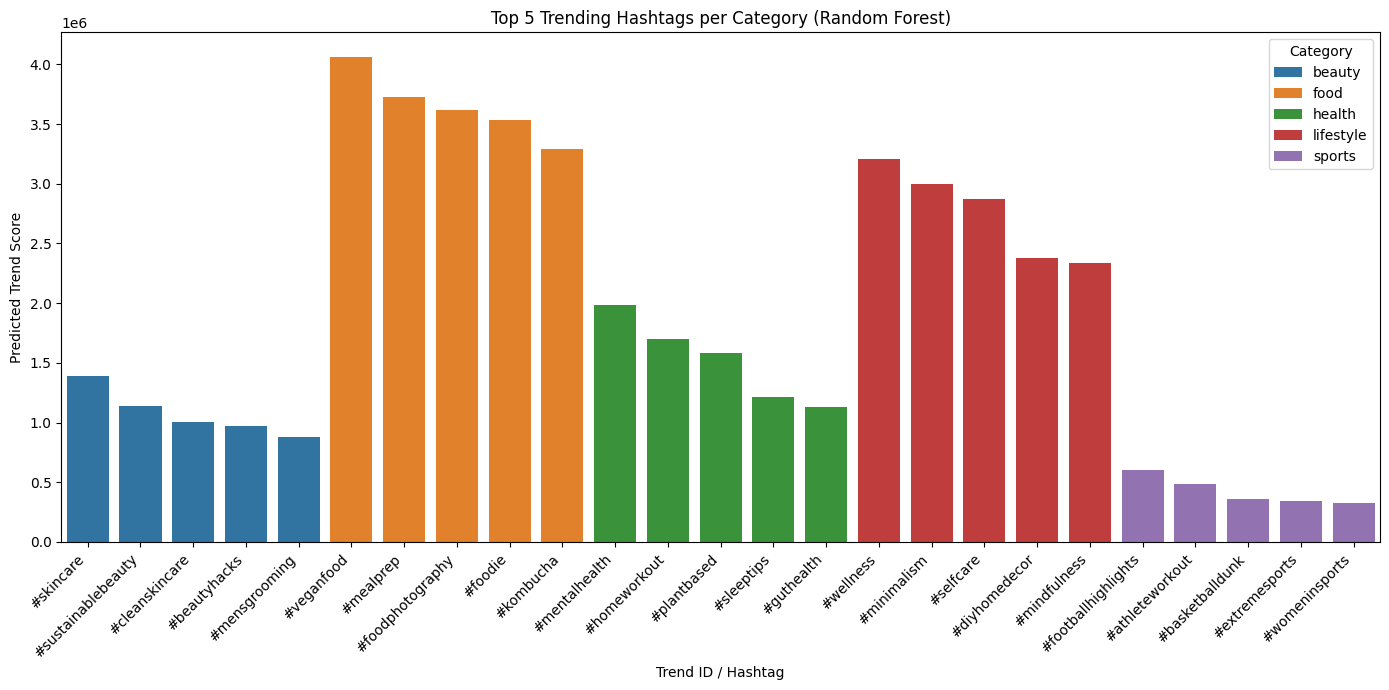

In [ ]:
df = pd.read_csv("trend_summary_ig.csv")
df_orig = pd.read_csv("merged_trends2_transformed.csv")[["trend_id", "category"]]

# Merge category into trend summary
df = df.merge(df_orig, on="trend_id", how="left")

# Fill missing values
df["volume"] = df["volume"].fillna(0)
df["engagement"] = df["engagement"].fillna(0)
df["growth_rate_7d"] = df["growth_rate_7d"].fillna(0)
df["acceleration"] = df.get("acceleration", 0).fillna(0)

# Lowercase category
df["category"] = df["category"].str.lower()

# Prepare features
features = ["volume", "engagement", "growth_rate_7d", "acceleration"]
X = df[features]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Synthetic target for Random Forest
y = df["volume"]*0.4 + df["engagement"]*0.3 + df["growth_rate_7d"]*0.2 + df["acceleration"]*0.1

# Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# Predict trend scores
df["predicted_score"] = model.predict(X_scaled)

# Rank and get top 5 per category
df["rank_in_category"] = df.groupby("category")["predicted_score"].rank(ascending=False, method="first")
top5_per_category = df[df["rank_in_category"] <= 5].copy()
top5_per_category = top5_per_category.sort_values(["category", "rank_in_category"])


# Plot top 5 per category
plt.figure(figsize=(14,7))
sns.barplot(
    data=top5_per_category,
    x="trend_id",
    y="predicted_score",
    hue="category",
    dodge=False,
    palette="tab10"
)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Trend ID / Hashtag")
plt.ylabel("Predicted Trend Score")
plt.title("Top 5 Trending Hashtags per Category (Random Forest)")
plt.legend(title="Category")
plt.tight_layout()
plt.show()